<h1 style="font-size:3rem; color: darkmagenta;">Data Aggregation and Group Operations:</h1>

<h1 style="font-size:2.3rem; color: darkcyan;">10.3 Apply: General split-apply-combine:</h1>

## Table of Contents

- 10.31  **[Apply: General split-apply-combine](#General)**
   
- 10.32  **[Quantile and Bucket Analysis](#Quantile)**

- 10.33  **[Filling Missing Values with Group-Specific Values](#Missing_Values)**

- 10.34  **[Example: Random Sampling and Permutation](#Random_Sampling)**
   
- 10.35  **[Example: Group-Wise Linear Regression](#Linear_Regression)**

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore") 

<a id="General"></a>
## 10.31 Apply: General split-apply-combine

The most general-purpose GroupBy method is apply, which is the subject of the rest of this section. As illustrated in Figure 10-2, `apply` splits the object being manipulated into pieces, invokes the passed function on each piece, and then attempts to concatenate the pieces together.

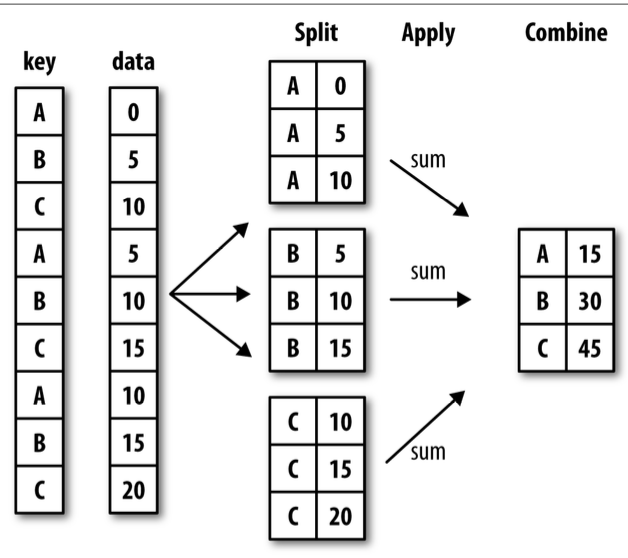

Returning to the tipping dataset from before, suppose you wanted to select the top five `tip_pct` values by group. First, write a function that selects the rows with the largest values in a particular column:

In [9]:
tips = pd.read_csv('tips.csv')
tips['tip_pct'] = tips['tip'] / tips['total_bill']

In [10]:
def top(df, n=5, column='tip_pct'):
    return df.sort_values(by=column)[-n:]

In [11]:
top(tips, n=6)

,total_bill,tip,smoker,day,time,size,tip_pct
109,14.31,4.00,Yes,Sat,Dinner,2,0.279525
183,23.17,6.50,Yes,Sun,Dinner,4,0.280535
232,11.61,3.39,No,Sat,Dinner,2,0.291990
67,3.07,1.00,Yes,Sat,Dinner,1,0.325733
178,9.60,4.00,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Yes,Sun,Dinner,2,0.710345


Now, if we group by `smoker`, say, and call `apply` with this function, we get the following:

In [12]:
tips.groupby('smoker').apply(top)

total_bill   tip smoker   day    time  size   tip_pct
smoker                                                           
No     88        24.71  5.85     No  Thur   Lunch     2  0.236746
       185       20.69  5.00     No   Sun  Dinner     5  0.241663
       51        10.29  2.60     No   Sun  Dinner     2  0.252672
       149        7.51  2.00     No  Thur   Lunch     2  0.266312
       232       11.61  3.39     No   Sat  Dinner     2  0.291990
Yes    109       14.31  4.00    Yes   Sat  Dinner     2  0.279525
       183       23.17  6.50    Yes   Sun  Dinner     4  0.280535
       67         3.07  1.00    Yes   Sat  Dinner     1  0.325733
       178        9.60  4.00    Yes   Sun  Dinner     2  0.416667
       172        7.25  5.15    Yes   Sun  Dinner     2  0.710345

What has happened here? The top function is called on each row group from the DataFrame, and then the results are glued together using `pandas.concat`, labeling the pieces with the group names. The result therefore has a hierarchical index whose inner level contains index values from the original DataFrame.

If you pass a function to `apply` that takes other arguments or keywords, you can pass these after the function:

In [13]:
tips.groupby(['smoker', 'day']).apply(top, n=1, column='total_bill')

total_bill    tip smoker   day    time  size   tip_pct
smoker day                                                             
No     Fri  94        22.75   3.25     No   Fri  Dinner     2  0.142857
       Sat  212       48.33   9.00     No   Sat  Dinner     4  0.186220
       Sun  156       48.17   5.00     No   Sun  Dinner     6  0.103799
       Thur 142       41.19   5.00     No  Thur   Lunch     5  0.121389
Yes    Fri  95        40.17   4.73    Yes   Fri  Dinner     4  0.117750
       Sat  170       50.81  10.00    Yes   Sat  Dinner     3  0.196812
       Sun  182       45.35   3.50    Yes   Sun  Dinner     3  0.077178
       Thur 197       43.11   5.00    Yes  Thur   Lunch     4  0.115982

Beyond these basic usage mechanics, getting the most out of `apply` may require some creativity. What occurs inside the function passed is up to you; it only needs to return a pandas object or a scalar value. The rest of this chapter will mainly consist of examples showing you how to solve various problems using `groupby`.

We earlier called describe on a GroupBy object:

In [15]:
result = tips.groupby('smoker')['tip_pct'].describe()

In [16]:
result

,count,mean,std,min,25%,50%,75%,max
smoker,,,,,,,,
No,151.0,0.159328,0.039910,0.056797,0.136906,0.155625,0.185014,0.291990
Yes,93.0,0.163196,0.085119,0.035638,0.106771,0.153846,0.195059,0.710345


In [17]:
result.unstack('smoker')

       smoker
count  No        151.000000
       Yes        93.000000
mean   No          0.159328
       Yes         0.163196
std    No          0.039910
       Yes         0.085119
min    No          0.056797
       Yes         0.035638
25%    No          0.136906
       Yes         0.106771
50%    No          0.155625
       Yes         0.153846
75%    No          0.185014
       Yes         0.195059
max    No          0.291990
       Yes         0.710345
dtype: float64

Inside GroupBy, when you invoke a method like `describe`, it is actually just a shortcut for:

In [ ]:
f = lambda x: x.describe() 
grouped.apply(f)

### Suppressing the Group Keys

In the preceding examples, you see that the resulting object has a hierarchical index formed from the group keys along with the indexes of each piece of the original object. You can disable this by passing `group_keys=False` to `groupby`:

In [19]:
tips.groupby('smoker', group_keys=False).apply(top)

,total_bill,tip,smoker,day,time,size,tip_pct
88,24.71,5.85,No,Thur,Lunch,2,0.236746
185,20.69,5.00,No,Sun,Dinner,5,0.241663
51,10.29,2.60,No,Sun,Dinner,2,0.252672
149,7.51,2.00,No,Thur,Lunch,2,0.266312
232,11.61,3.39,No,Sat,Dinner,2,0.291990
109,14.31,4.00,Yes,Sat,Dinner,2,0.279525
183,23.17,6.50,Yes,Sun,Dinner,4,0.280535
67,3.07,1.00,Yes,Sat,Dinner,1,0.325733
178,9.60,4.00,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Yes,Sun,Dinner,2,0.710345


<a id="Quantile"></a>
## 10.32 Quantile and Bucket Analysis

As you may recall from Chapter 8, pandas has some tools, in particular `cut` and `qcut`, for slicing data up into buckets with bins of your choosing or by sample quantiles. Combining these functions with `groupby` makes it convenient to perform bucket or quantile analysis on a dataset. Consider a simple random dataset and an equal-length bucket categorization using `cut`:

In [21]:
frame = pd.DataFrame({'data1': np.random.randn(1000),
                      'data2': np.random.randn(1000)})
quartiles = pd.cut(frame.data1, 4)
quartiles[:10]

0    (-1.683, -0.0893]
1       (1.504, 3.097]
2       (1.504, 3.097]
3    (-1.683, -0.0893]
4     (-0.0893, 1.504]
5       (1.504, 3.097]
6     (-0.0893, 1.504]
7    (-1.683, -0.0893]
8    (-1.683, -0.0893]
9     (-0.0893, 1.504]
Name: data1, dtype: category
Categories (4, interval[float64, right]): [(-3.282, -1.683] < (-1.683, -0.0893] < (-0.0893, 1.504] < (1.504, 3.097]]

The `Categorical` object returned by cut can be passed directly to `groupby`. So we could compute a set of statistics for the `data2` column like so:

In [22]:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}

grouped = frame.data2.groupby(quartiles)

grouped.apply(get_stats).unstack()

,min,max,count,mean
data1,,,,
"(-3.282, -1.683]",-1.261288,1.559265,40.0,0.162214
"(-1.683, -0.0893]",-2.400685,3.139854,418.0,0.009803
"(-0.0893, 1.504]",-2.964640,3.663944,471.0,0.055692
"(1.504, 3.097]",-2.346138,2.823882,71.0,0.055849


These were equal-length buckets; to compute equal-size buckets based on sample quantiles, use `qcut`. I’ll pass `labels=False` to just get quantile numbers:

In [23]:
# Return quantile numbers
grouping = pd.qcut(frame.data1, 10, labels=False)

grouped = frame.data2.groupby(grouping)

grouped.apply(get_stats).unstack()

,min,max,count,mean
data1,,,,
0,-1.821918,1.806045,100.0,0.133669
1,-2.320160,2.492274,100.0,-0.129916
2,-2.240155,2.234532,100.0,0.005908
3,-1.838250,2.863958,100.0,0.112167
4,-2.400685,3.139854,100.0,-0.003223
5,-1.833216,3.201743,100.0,0.025803
6,-2.264705,3.361020,100.0,-0.041946
7,-2.049225,2.396068,100.0,0.182559
8,-2.964640,2.913792,100.0,-0.009632


<a id="Missing_Values"></a>
## 10.33 Example: Filling Missing Values with Group-Specific Values

When cleaning up missing data, in some cases you will replace data observations using `dropna`, but in others you may want to impute (fill in) the null (NA) values using a fixed value or some value derived from the data. `fillna` is the right tool to use; for example, here we fill in NA values with the mean:

In [25]:
s = pd.Series(np.random.randn(6))
s

0   -0.649887
1    2.140496
2   -1.127918
3    0.421814
4    1.530762
5    0.882158
dtype: float64

In [27]:
s[::2] = np.nan
s

0         NaN
1    2.140496
2         NaN
3    0.421814
4         NaN
5    0.882158
dtype: float64

In [28]:
s.fillna(s.mean())

0    1.148156
1    2.140496
2    1.148156
3    0.421814
4    1.148156
5    0.882158
dtype: float64

Suppose you need the fill value to vary by group. One way to do this is to group the data and use `apply` with a function that calls `fillna` on each data chunk. Here is some sample data on US states divided into eastern and western regions:

In [29]:
states = ['Ohio', 'New York', 'Vermont', 'Florida',
          'Oregon', 'Nevada', 'California', 'Idaho']
group_key = ['East'] * 4 + ['West'] * 4
data = pd.Series(np.random.randn(8), index=states)
data

Ohio          1.383479
New York     -0.685163
Vermont       2.005121
Florida       0.514146
Oregon        0.984609
Nevada        0.012463
California   -0.873483
Idaho         0.213610
dtype: float64

Note that the syntax `['East']` * 4 produces a list containing four copies of the elements in ['East']. Adding lists together concatenates them.

Let’s set some values in the data to be missing:

In [31]:
data[['Vermont', 'Nevada', 'Idaho']] = np.nan
data

Ohio          1.383479
New York     -0.685163
Vermont            NaN
Florida       0.514146
Oregon        0.984609
Nevada             NaN
California   -0.873483
Idaho              NaN
dtype: float64

In [32]:
data.groupby(group_key).mean()

East    0.404154
West    0.055563
dtype: float64

We can fill the NA values using the group means like so:

In [33]:
fill_mean = lambda g: g.fillna(g.mean())

In [34]:
data.groupby(group_key).apply(fill_mean)

Ohio          1.383479
New York     -0.685163
Vermont       0.404154
Florida       0.514146
Oregon        0.984609
Nevada        0.055563
California   -0.873483
Idaho         0.055563
dtype: float64

In another case, you might have predefined fill values in your code that vary by group. Since the groups have a `name` attribute set internally, we can use that:

In [37]:
fill_values = {'East': 0.5, 'West': -1}
fill_func = lambda g: g.fillna(fill_values[g.name])
data.groupby(group_key).apply(fill_func)

Ohio          1.383479
New York     -0.685163
Vermont       0.500000
Florida       0.514146
Oregon        0.984609
Nevada       -1.000000
California   -0.873483
Idaho        -1.000000
dtype: float64

<a id="Random_Sampling"></a>
## 10.34 Example: Random Sampling and Permutation

Suppose you wanted to draw a random sample (with or without replacement) from a large dataset for Monte Carlo simulation purposes or some other application. There are a number of ways to perform the “draws”; here we use the `sample` method for Series.

To demonstrate, here’s a way to construct a deck of English-style playing cards:

In [39]:
# Hearts, Spades, Clubs, Diamonds
suits = ['H', 'S', 'C', 'D']
card_val = (list(range(1, 11)) + [10] * 3) * 4
base_names = ['A'] + list(range(2, 11)) + ['J', 'K', 'Q']
cards = []
for suit in ['H', 'S', 'C', 'D']:
    cards.extend(str(num) + suit for num in base_names)

deck = pd.Series(card_val, index=cards)

So now we have a Series of length 52 whose index contains card names and values are the ones used in Blackjack and other games (to keep things simple, I just let the ace 'A' be 1):

In [40]:
deck[:13]

AH      1
2H      2
3H      3
4H      4
5H      5
6H      6
7H      7
8H      8
9H      9
10H    10
JH     10
KH     10
QH     10
dtype: int64

Now, based on what I said before, drawing a hand of five cards from the deck could be written as:

In [41]:
def draw(deck, n=5):
    return deck.sample(n)

In [42]:
draw(deck)

2C     2
5H     5
3H     3
9C     9
QS    10
dtype: int64

Suppose you wanted two random cards from each suit. Because the suit is the last character of each card name, we can group based on this and use `apply`:

In [43]:
get_suit = lambda card: card[-1] # last letter is suit

In [44]:
deck.groupby(get_suit).apply(draw, n=2)

C  2C     2
   8C     8
D  4D     4
   KD    10
H  5H     5
   9H     9
S  2S     2
   JS    10
dtype: int64

Alternatively, we could write:

In [45]:
deck.groupby(get_suit, group_keys=False).apply(draw, n=2)

7C    7
9C    9
9D    9
4D    4
8H    8
2H    2
4S    4
9S    9
dtype: int64

In [ ]:
<a id="Group Weighted Average"></a>
## 10.34 Example: Example: Group Weighted Average and Correlation

Under the split-apply-combine paradigm of groupby, operations between columns in a DataFrame or two Series, such as a group weighted average, are possible. As an example, take this dataset containing group keys, values, and some weights:

In [46]:
df = pd.DataFrame({'category': ['a', 'a', 'a', 'a',
                               'b', 'b', 'b', 'b'],
                   'data': np.random.randn(8),
                   'weights': np.random.rand(8)})

In [47]:
df

,category,data,weights
0,a,0.645303,0.217956
1,a,0.416865,0.269437
2,a,-1.498674,0.805938
3,a,-0.327656,0.090651
4,b,-0.230250,0.421167
5,b,1.253817,0.790411
6,b,0.413524,0.888269
7,b,0.876098,0.553333


The group weighted average by `category` would then be:

In [50]:
grouped = df.groupby('category')

In [51]:
get_wavg = lambda g: np.average(g['data'], weights=g['weights'])

In [52]:
grouped.apply(get_wavg)

category
a   -0.711406
b    0.658135
dtype: float64

As another example, consider a financial dataset originally obtained from Yahoo! Finance containing end-of-day prices for a few stocks and the S&P 500 index (the SPX symbol):

In [55]:
close_px = pd.read_csv('stock_px.csv', parse_dates=True,
                      index_col=0)

In [56]:
close_px.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2214 entries, 2003-01-02 to 2011-10-14
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    2214 non-null   float64
 1   MSFT    2214 non-null   float64
 2   XOM     2214 non-null   float64
 3   SPX     2214 non-null   float64
dtypes: float64(4)
memory usage: 86.5 KB


In [57]:
close_px[-4:]

,AAPL,MSFT,XOM,SPX
2011-10-11,400.29,27.00,76.27,1195.54
2011-10-12,402.19,26.96,77.16,1207.25
2011-10-13,408.43,27.18,76.37,1203.66
2011-10-14,422.00,27.27,78.11,1224.58


One task of interest might be to compute a DataFrame consisting of the yearly correlations of daily returns (computed from percent changes) with `SPX`. As one way to do this, we first create a function that computes the pairwise correlation of each column with the `'SPX'` column:

In [58]:
spx_corr = lambda x: x.corrwith(x['SPX'])

Next, we compute percent change on `close_px` using `pct_change`:

In [59]:
rets = close_px.pct_change().dropna()

Lastly, we group these percent changes by year, which can be extracted from each row
label with a one-line function that returns the `year` attribute of each `datetime` label:

In [60]:
get_year = lambda x: x.year

by_year = rets.groupby(get_year)

by_year.apply(spx_corr)

,AAPL,MSFT,XOM,SPX
2003,0.541124,0.745174,0.661265,1.0
2004,0.374283,0.588531,0.557742,1.0
2005,0.467540,0.562374,0.631010,1.0
2006,0.428267,0.406126,0.518514,1.0
2007,0.508118,0.658770,0.786264,1.0
2008,0.681434,0.804626,0.828303,1.0
2009,0.707103,0.654902,0.797921,1.0
2010,0.710105,0.730118,0.839057,1.0
2011,0.691931,0.800996,0.859975,1.0


You could also compute inter-column correlations. Here we compute the annual correlation between Apple and Microsoft:

In [61]:
by_year.apply(lambda g: g['AAPL'].corr(g['MSFT']))

2003    0.480868
2004    0.259024
2005    0.300093
2006    0.161735
2007    0.417738
2008    0.611901
2009    0.432738
2010    0.571946
2011    0.581987
dtype: float64

<a id="Linear_Regression"></a>
## 10.35 Example: Group-Wise Linear Regression

In the same theme as the previous example, you can use `groupby` to perform more complex group-wise statistical analysis, as long as the function returns a pandas object or scalar value. For example, we can define the following `regress` function (using the `statsmodels` econometrics library), which executes an ordinary least squares (OLS) regression on each chunk of data:

In [62]:
import statsmodels.api as sm

def regress(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    return result.params

Now, to run a yearly linear regression of *AAPL* on *SPX* returns, execute:

In [63]:
by_year.apply(regress, 'AAPL', ['SPX'])

,SPX,intercept
2003,1.195406,0.000710
2004,1.363463,0.004201
2005,1.766415,0.003246
2006,1.645496,0.000080
2007,1.198761,0.003438
2008,0.968016,-0.001110
2009,0.879103,0.002954
2010,1.052608,0.001261
2011,0.806605,0.001514
